In [1]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import os

import time
from datetime import timedelta

#### Batch size
If memory error, reduce the batch_size.

In [2]:
batch_size = 32
num_workers = 1

#### [ImageFolder](https://github.com/pytorch/vision/blob/master/torchvision/datasets/folder.py)
A generic data loader where the samples are arranged in this way:
```
    root/dog/xxx.png
    root/dog/xxy.png
    root/dog/xxz.png
    root/cat/123.png
    root/cat/nsdf3.png
    root/cat/asd932_.png
    
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
```

In [3]:
# Data loading code
datasetsdir = os.path.join('datasets', 'keras')
traindir = os.path.join(datasetsdir, 'train')
valdir = os.path.join(datasetsdir, 'val')
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(traindir, transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
    ])),
    batch_size=batch_size, shuffle=True,
    num_workers=num_workers)

val_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(valdir, transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize,
    ])),
    batch_size=batch_size, shuffle=False,
    num_workers=num_workers)

classes = [d for d in os.listdir(traindir) if os.path.isdir(os.path.join(traindir, d))]
classes.sort()

Train + Validation

In [4]:
def train(model, loader, loss_fn, optimizer, num_epochs = 1):
    start_time = time.time()
    for epoch in range(num_epochs):
        print('Starting epoch %d / %d' % (epoch + 1, num_epochs))
        model.train()
        batch_start = time.time()
        for t, (x, y) in enumerate(loader):
            x_var = x.cuda()
            y_var = y.cuda()

            scores = model(x_var)
            
            loss = loss_fn(scores, y_var)
            if (t + 1) % 100 == 0:
                print('t = %d, loss = %.4f, duration = %s' % (t + 1, loss.item(), timedelta(seconds=time.time() - batch_start)))
                batch_start = time.time()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    print('duration = %s' % timedelta(seconds=time.time() - start_time))

def check_accuracy(model, loader):
    num_correct = 0
    num_samples = 0
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    start_time = time.time()
    for x, y in loader:
        with torch.no_grad():
            x_var = x.cuda()

            scores = model(x_var)
            _, preds = scores.data.cpu().max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    print('duration = %s' % timedelta(seconds=time.time() - start_time))

#### [Pre-trained models](https://pytorch.org/docs/master/torchvision/models.html)

- [VGG16](https://arxiv.org/abs/1409.1556)
- [ResNet34](https://arxiv.org/abs/1512.03385)

As always, add one more FC layer or replace the last FC layer with the number of output classes.

In [5]:
def vgg16(pretrained=True):
    model = models.vgg16(pretrained=pretrained)
    def set_untrainable(layer):
        for p in layer.parameters():
            p.requires_grad = False

    for layer in model.children():
        layer.apply(set_untrainable)
    model.classifier = nn.Sequential(*(list(model.classifier.children()) + [nn.ReLU(inplace=True), nn.Linear(1000, 2)]))
    # del.features = torch.nn.DataParallel(model.features)
    model.cuda()
    return model
    
def resnet34(pretrained=True):
    model = models.resnet34(pretrained=pretrained)
    def set_untrainable(layer):
        for p in layer.parameters():
            p.requires_grad = False

    for layer in model.children():
        layer.apply(set_untrainable)
    model.fc = nn.Linear(512, 2)
    model.cuda()
    return model

#### ResNet34

In [6]:
model = resnet34()

loss_fn = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad], lr=1e-2)

train(model, train_loader, loss_fn, optimizer, num_epochs=1)
check_accuracy(model, val_loader)

Starting epoch 1 / 1
t = 100, loss = 0.0749, duration = 0:00:18.672134
t = 200, loss = 0.0680, duration = 0:00:16.640001
t = 300, loss = 0.9872, duration = 0:00:16.774000
t = 400, loss = 0.1159, duration = 0:00:16.787435
t = 500, loss = 0.0466, duration = 0:00:16.618001
t = 600, loss = 0.3448, duration = 0:00:16.582690
t = 700, loss = 0.0462, duration = 0:00:16.578005
duration = 0:02:01.688264
Got 1970 / 2000 correct (98.50)
duration = 0:00:12.297550


#### [Serialization](https://pytorch.org/docs/master/notes/serialization.html)

- Save and load only the model parameters (recommanded):

```python
    # Save
    torch.save(the_model.state_dict(), PATH)
    # Load
    the_model = TheModelClass(*args, **kwargs)
    the_model.load_state_dict(torch.load(PATH))
```

- Save and load the entire model:

```python
    # Save
    torch.save(the_model, PATH)
    # Load
    the_model = torch.load(PATH)
```

In [10]:
torch.save(model.state_dict(), 'ResNet34.pth')

#### VGG16

In [8]:
model = vgg16()

loss_fn = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad], lr=1e-2)

train(model, train_loader, loss_fn, optimizer, num_epochs=1)
check_accuracy(model, val_loader)

Starting epoch 1 / 1
t = 100, loss = 1.9290, duration = 0:00:48.474305
t = 200, loss = 0.4876, duration = 0:00:47.994678
t = 300, loss = 0.0004, duration = 0:00:48.264209
t = 400, loss = 0.1002, duration = 0:00:49.223241
t = 500, loss = 0.3139, duration = 0:00:48.351022
t = 600, loss = 0.0028, duration = 0:00:47.076995
t = 700, loss = 0.8571, duration = 0:00:47.766974
duration = 0:05:45.750753
Got 1957 / 2000 correct (97.85)
duration = 0:00:31.507473


In [9]:
torch.save(model.state_dict(), 'vgg16.pth' )

#### Run model on test data

In [8]:
import matplotlib
import matplotlib.pyplot as plt
import itertools
from PIL import Image
%matplotlib inline  

In [11]:
testdir = os.path.join(datasetsdir, 'test')

test_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(testdir, transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize,
    ])),
    batch_size=batch_size, shuffle=False,
    num_workers=num_workers)

In [12]:
images = [os.path.join(os.path.join(testdir, 'unknown'), f) for f in sorted(os.listdir(os.path.join(testdir, 'unknown')))]

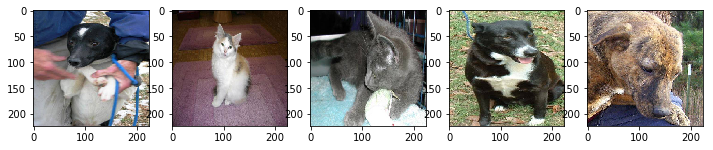

In [13]:
f = plt.figure(figsize=(12,6))
for i, x in enumerate(images[:5]):
    f.add_subplot(1, 5, i + 1)
    plt.imshow(Image.open(x).resize((224,224)))

In [14]:
def run_test(model, loader):
    preds = []
    model.eval()
    start_time = time.time()
    for x, _ in loader:
        with torch.no_grad():
            x_var = x.cuda()

            scores = model(x_var)
            _, _preds = scores.data.cpu().max(1)
            preds += _preds.tolist()
    print('duration = %s' % timedelta(seconds=time.time() - start_time))
    return preds

In [15]:
preds = run_test(model, test_loader)
results = zip(images, [classes[p] for p in preds])

duration = 0:01:11.735326


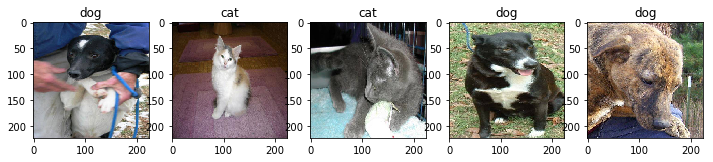

In [16]:
f = plt.figure(figsize=(12,6))
for i, (x, y) in enumerate(itertools.islice(results, 5)):
    f.add_subplot(1, 5, i + 1)
    plt.imshow(Image.open(x).resize((224,224)))
    plt.title(y)